In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset
import torchaudio
from torch.utils.data import DataLoader
import os
import numpy as np
import torch.nn.functional as F
from konlpy.tag import Okt

In [5]:
df = pd.read_csv("text/part1.csv")

In [6]:
df

,id,form,original_form,speaker_id,start,end,age,sex
0,SDRW2000000319.1.1.1,병역 특례를 받아,병역 특례를 받아,SD2001645,4.04903,5.83905,10대,여성
1,SDRW2000000319.1.1.2,법정 봉사활동 기 시간을 채워야 하는,법정 봉사활동 기 시간을 채워야 하는,SD2001645,5.84901,8.89405,10대,여성
2,SDRW2000000319.1.1.3,예술,예술,SD2001645,8.90407,9.52506,10대,여성
3,SDRW2000000319.1.1.4,또는 체육 요원의 절반가량이,또는 체육 요원의 절반가량이,SD2001645,9.53506,12.05203,10대,여성
4,SDRW2000000319.1.1.5,허위 자료를 내거나,허위 자료를 내거나,SD2001645,12.06204,13.79504,10대,여성
...,...,...,...,...,...,...,...,...
213188,SDRW2000000418.1.1.326,우선,우선,SD2000552,908.12707,909.98106,10대,여성
213189,SDRW2000000418.1.1.327,맛있는 음식들 먹으면서,맛있는 음식들 먹으면서,SD2000552,909.99104,912.25405,10대,여성
213190,SDRW2000000418.1.1.328,겝,겝,SD2000552,912.26403,913.64807,10대,여성
213191,SDRW2000000418.1.1.329,먹으면서 저도 같이 맛있어 보이는 느낌이라서,먹으면서 저도 같이 맛있어 보이는 느낌이라서,SD2000552,913.65802,917.87305,10대,여성


In [29]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)  # Additional GRU layer
        self.gru3 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.gru4 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
#         self.init = nn.init.xavier_normal_(tensor, gain=1.0)
#         self.softmax = nn.Softmax()
        
    def forward(self, x):
        h0 = nn.init.xavier_uniform_(torch.randn(1, x.size(0), self.hidden_size).to(x.device), gain=1.0)
        #c0 = torch.randn(1, x.size(0), self.hidden_size).to(x.device)
        hidden_state0 = h0.cpu().detach().numpy()
        output, hidden1 = self.gru1(x, (h0))
        hidden_state1 = hidden1.cpu().detach().numpy()
        output, hidden2 = self.gru2(self.relu(output), hidden1) # Pass output through the second LSTM layer
        hidden_state2 = hidden2.cpu().detach().numpy()
        output, hidden3 = self.gru3(self.relu(output), hidden2) # Pass output through the second LSTM layer
        hidden_state3 = hidden3.cpu().detach().numpy()
        output, hidden4 = self.gru4(self.relu(output), hidden3) # Pass output through the second LSTM layer
        hidden_state4 = hidden4.cpu().detach().numpy()
        output = self.fc(self.relu(output[:, -1, :]))
        return output, [hidden_state0, hidden_state1, hidden_state2]

In [8]:
df.isnull().sum()

id                0
form             39
original_form     0
speaker_id        0
start             0
end               0
age               0
sex               0
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df['sex'].value_counts()

sex
여성    149045
남성     64109
Name: count, dtype: int64

In [11]:
df = df[df['sex'] == '여성']

In [12]:
df = df.reset_index()

In [13]:
df['sex'].value_counts()

sex
여성    149045
Name: count, dtype: int64

In [14]:
okt = Okt()
df['token']=df['form'].apply(okt.morphs)

In [15]:
df

,index,id,form,original_form,speaker_id,start,end,age,sex,token
0,0,SDRW2000000319.1.1.1,병역 특례를 받아,병역 특례를 받아,SD2001645,4.04903,5.83905,10대,여성,"[병역, 특례, 를, 받아]"
1,1,SDRW2000000319.1.1.2,법정 봉사활동 기 시간을 채워야 하는,법정 봉사활동 기 시간을 채워야 하는,SD2001645,5.84901,8.89405,10대,여성,"[법정, 봉사활동, 기, 시간, 을, 채워야, 하는]"
2,2,SDRW2000000319.1.1.3,예술,예술,SD2001645,8.90407,9.52506,10대,여성,[예술]
3,3,SDRW2000000319.1.1.4,또는 체육 요원의 절반가량이,또는 체육 요원의 절반가량이,SD2001645,9.53506,12.05203,10대,여성,"[또는, 체육, 요원, 의, 절반, 가량, 이]"
4,4,SDRW2000000319.1.1.5,허위 자료를 내거나,허위 자료를 내거나,SD2001645,12.06204,13.79504,10대,여성,"[허위, 자료, 를, 내, 거나]"
...,...,...,...,...,...,...,...,...,...,...
149040,213188,SDRW2000000418.1.1.326,우선,우선,SD2000552,908.12707,909.98106,10대,여성,[우선]
149041,213189,SDRW2000000418.1.1.327,맛있는 음식들 먹으면서,맛있는 음식들 먹으면서,SD2000552,909.99104,912.25405,10대,여성,"[맛있는, 음식, 들, 먹으면서]"
149042,213190,SDRW2000000418.1.1.328,겝,겝,SD2000552,912.26403,913.64807,10대,여성,[겝]
149043,213191,SDRW2000000418.1.1.329,먹으면서 저도 같이 맛있어 보이는 느낌이라서,먹으면서 저도 같이 맛있어 보이는 느낌이라서,SD2000552,913.65802,917.87305,10대,여성,"[먹으면서, 저, 도, 같이, 맛있어, 보이는, 느낌, 이라서]"


In [16]:
bin_list = []
for i in range(len(df)):
    bin_list.append(df["token"][i])
bin_list = sum(bin_list,[])

In [17]:
bin_list2 = []
for i in range(len(bin_list)):
    temp = bin_list[i]
    if temp not in bin_list2:
        bin_list2.append(temp)

In [18]:
lookup = {tkn: i+2 for i, tkn in enumerate(bin_list2)}
lookup["unk"] = 0
lookup["pad"] = 1

In [19]:
#lookup

In [20]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, wav_dir, bin_list):
        self.data = dataframe
        self.wav_dir = wav_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_id = self.data.iloc[index]['id']
        wav_path = os.path.join(self.wav_dir, f'{file_id}.wav')
        audio, _ = torchaudio.load(wav_path)
        text = self.data.iloc[index]['token']
        
        token_indices = [lookup[t] for t in text]
        desired_length = 100
        
        token_indices += [1] * (desired_length - len(token_indices))
        token_indices = torch.tensor(token_indices).type(torch.float32)

        return audio, token_indices

In [21]:
num_epochs = 256
batch_size = 100
learning_rate = 2e-03
num_classes = len(df)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
wav_dir = './wav_all_stereo(fixed_length)'
dataset = CustomDataset(df[:1000], wav_dir, bin_list2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
audio, text = dataset[0]
print("Audio:", audio.shape)
print("Text:", text.shape)

Audio: torch.Size([2, 221616])
Text: torch.Size([100])


In [24]:
input_size = 221616
hidden_size = 100
output_size = 100

In [25]:
model = GRUModel(input_size, hidden_size, output_size).to(device)
# criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=False)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)
total_step = len(dataloader)

In [ ]:
reverse = dict(map(reversed,lookup.items()))

In [35]:
# def layer_visualization(hidden_states, text):
#     plt.figure(figsize=(7 * len(hidden_states), 4)) # Adjust the figure size
#     plt.subplots_adjust(wspace=0.2, hspace=0.5)
#     for layer_idx, hidden_state in enumerate(hidden_states):
#         plt.subplot(1, len(hidden_states), layer_idx + 1) # Create a subplot for each layer
#         plt.title(f'Hidden state values in layer {layer_idx + 1}')
#         sns.heatmap(hidden_state[0,:20])
#         print([reverse[int(i)] for i in text[:10,:20]])
# #         plt.xlabel([reverse[int(i)] for i in text[0,:20]])
# #         plt.imshow(hidden_state[0], aspect='auto', cmap='hot')
#         plt.axis("off")
# #         plt.colorbar()
#     plt.show() # Call `plt.show()` once after creating all subplots

In [26]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
        '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
        '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
        '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']

cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

def layer_visualization(hidden_states, text):
    plt.figure(figsize=(7 * len(hidden_states), 4)) # Adjust the figure size
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    for layer_idx, hidden_state in enumerate(hidden_states):
        plt.subplot(1, len(hidden_states), layer_idx + 1) # Create a subplot for each layer
        plt.title(f'Hidden state values in layer {layer_idx + 1}')
        sns.heatmap(hidden_state[0,:20], cmap=cmap)
        print([reverse[int(i)] for i in text[:10,:20]])
        plt.axis("off")
    plt.show() # Call `plt.show()` once after creating all subplots

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from time import time
timelist = []
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    start = time()
    if (epoch + 1) % 2 == 0:
        torch.save(model, "./model/Speech2Text-sophia.pt")

    for i, (audio, text) in enumerate(dataloader):
        audio = audio.to(device)
        text = text.to(device)

        outputs,hidden_states = model(audio)
#         print(outputs.dtype)
#         print(text.dtype)
#         input_lengths = torch.full(size=(batch_size,), fill_value=100, dtype=torch.long)
#         output_lengths = torch.full(size=(batch_size,), fill_value=100, dtype=torch.long)
#         loss = criterion(outputs, 
#                          text, 
#                          input_lengths, 
#                          output_lengths)
        loss = criterion(outputs, text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        text = text.view(-1, 1)
        total_correct += (predicted == text).sum().item()

#         if (i + 1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    scheduler.step()
    epoch_loss = total_loss / (batch_size * total_step)
    epoch_acc = total_correct / (batch_size * total_step)
    end = time()
    timelist.append(end-start)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time Duration : {end - start:.4f}:')
    layer_visualization(hidden_states, text)

OutOfMemoryError: CUDA out of memory. Tried to allocate 434.00 MiB (GPU 0; 19.70 GiB total capacity; 773.85 MiB already allocated; 51.00 MiB free; 1.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Text(0, 0.5, 'time')

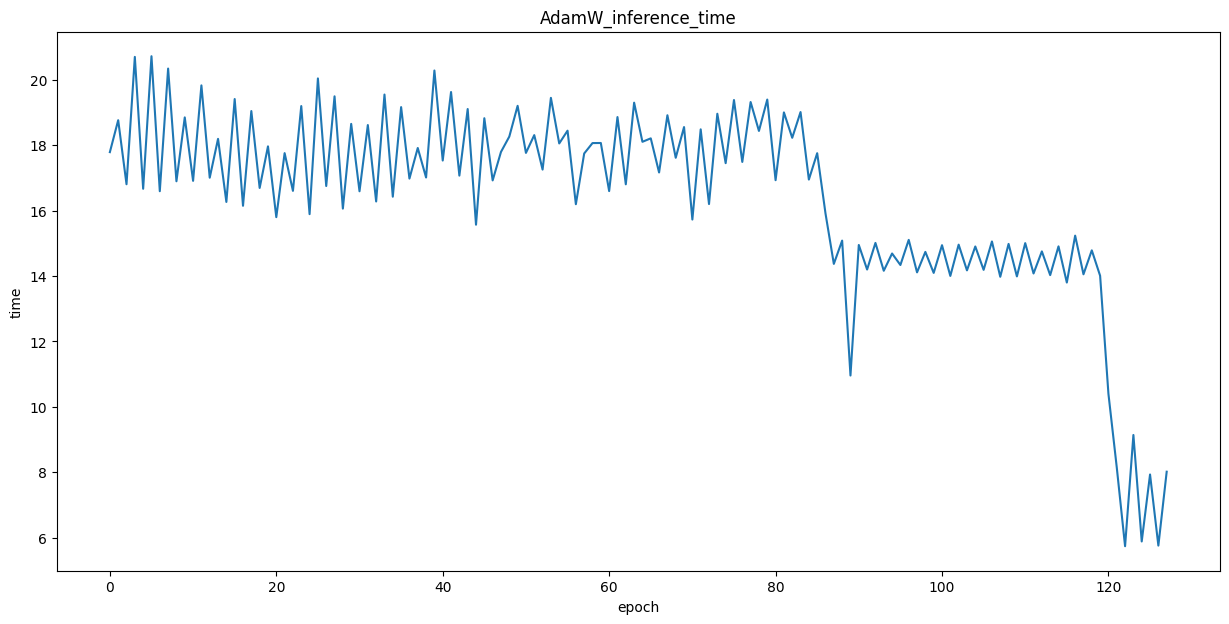

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(timelist)
plt.title("AdamW_inference_time")
plt.xlabel("epoch")
plt.ylabel("time")
plt.show()

In [ ]:
def predict(model, input_file):
    model.eval()  # 모델을 평가 모드로 설정
    
    audio, _ = torchaudio.load(input_file)  
    audio = audio.unsqueeze(0).to(device) 

    output = model(audio) 

    return output.int().detach()

In [ ]:
output = predict(model,'./wav_all_stereo(fixed_length)/SDRW2000000414.1.1.18.wav')

In [ ]:
output[0,1]

In [33]:
reverse = dict(map(reversed,lookup.items()))

In [ ]:
out = []
for i in range(len(output[0])):
    out.append(reverse[output[0,i].item()])
out